In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

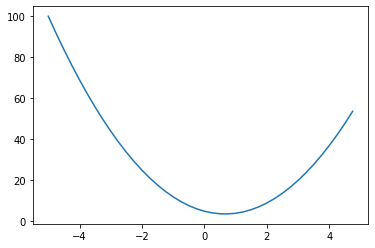

In [4]:
#-5 ~ 5까지 0.25간격으로 좌표 만들기
xs = np.arange(-5, 5, 0.25)
#x값에 대응되는 y값
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# fx = 3x^2 -4x + 5
# dfx = 6x -4 -> 값이 0이 되게 하면 0에 가깝게 함, 여기서는 2/3
h = 0.000000001
x = 2/3
# 미분의 정의
(f(x+h) -f(x)) / h

0.0

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
#a에 대해서 미분
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

# 미분하려면 2개의 값이 필요
# 오리지널 값을 d1
d1 = a * b + c # f(a)
a+=h
d2= a * b + c # f(a+h)

print(d1)
print(d2)

# 얼마나 영향을 미치고 있는지
print('slope', (d2-d1)/h)

4.0
3.999699999999999
slope -3.000000000010772


In [43]:
class Value:
  
  # 어디서부터 왔는지 trace를 하기 위해 children 추가, 기호를 나타내기 위해 op추가, label으로 변수명 추가
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0        
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  #원하는 형태로 데이터를 나오게 하는 함수  
  def __repr__(self):
    return f"Value(data={self.data})"  

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other): # otehr + self (1 + a) : other = 1, self = a
    return self + other

  def __neg__(self): # self
    return self * -1

  def __sub__(self, other):
    return self + (-other)


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)    
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/folat"    
    out = Value(self.data ** other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * (other**(-1))

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out

  def exp(self):
    x = self.data
    t = math.exp(x)
    out = Value(t, (self, ), 'exp')

    def _backward():
      self.grad = t * out.grad

    out._backward = _backward

    return out

  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for n in reversed(topo):
      n._backward()



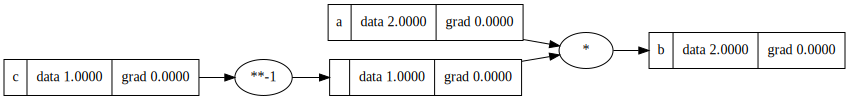

In [15]:
a = Value(2.0, label='a')
c = Value(1.0, label = 'c')

b = a / c

b.label = 'b'
# a + 1
# a.__add__(1)

draw_dot(b)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f

L.label = 'L'
print(L._prev)


In [14]:
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
#컴퓨테이셔널 그래프 그리기
draw_dot(L)

In [91]:
import random
class Neuron:
  def __init__(self, num_of_input):
    self.w = [Value(random.uniform(-1,1)) for _ in range(num_of_input)] # weight에 대한 개수
    self.b = Value(random.uniform(-1,1))  # 이에 대한 value 값을 만들어 줌

  def __call__(self, x):
    # w * x + b
    act = sum(wi * xi for wi, xi in (zip(self.w, x))) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, num_of_input, num_of_output):
    self.neurons = [ Neuron(num_of_input) for _ in range(num_of_output)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # 맨 마지막이 1개이면 list를 벗김

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for n in self.nuerons:
    #   params.extend(n.parameters())
    # return params

class MLP:
  def __init__(self, num_of_inputs, num_of_outputs):
    sz = [num_of_inputs] + num_of_outputs
    self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(num_of_outputs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [155]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
print(len(n.parameters()))

41


In [156]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [166]:
for k in range(20):
#forward pass
  ypred = [ n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

#for yi in ypred:
  #print(yi)
#for ygt, yout in zip(ys, ypred):
  #print((yout - ygt)**2)

#backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

#update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  print(k, loss.data)


0 0.06608100564589868
1 0.0655468719076325
2 0.06503068381504779
3 0.06477508387042794
4 0.06453614981749434
5 0.06428794773688111
6 0.06359257997429466
7 0.06306685250095417
8 0.06256809829441559
9 0.06236058119465117
10 0.06191688743458139
11 0.06176174433349693
12 0.06132786741741007
13 0.060848824655333394
14 0.0604107692100978
15 0.059991632807698196
16 0.05975599982708066
17 0.059342844788232416
18 0.05915219381358487
19 0.05885525980090247


In [105]:
n.layers[0].neurons[0].w[1]

Value(data=-0.7998188817582489)

In [130]:
n.layers[0].neurons[0].w[1].grad

-0.0006924129611943438

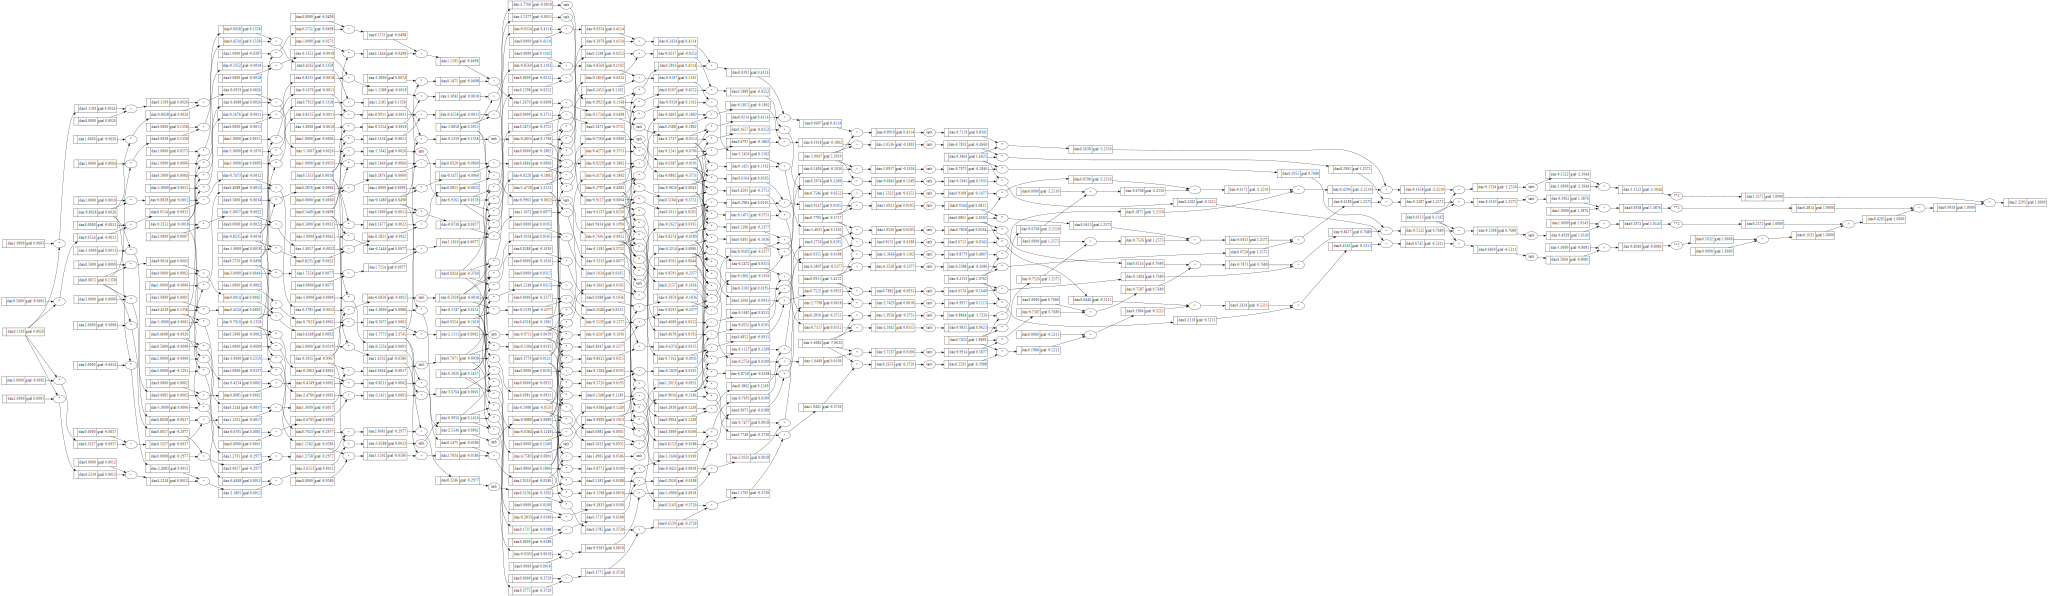

In [149]:
draw_dot(loss)

In [ ]:
# def lol():
  
#   h = 0.001
  
#   a = Value(2.0, label='a')
#   b = Value(-3.0, label='b')
#   c = Value(10.0, label='c')
#   e = a*b; e.label = 'e'
#   d = e + c; d.label = 'd'
#   f = Value(-2.0, label='f')
#   L = d * f; L.label = 'L'
#   L1 = L.data
  
#   a = Value(2.0, label='a')
#   b = Value(-3.0, label='b')
#   f.data += h
#   c = Value(10.0, label='c')
#   e = a*b; e.label = 'e'
#   d = e + c; d.label = 'd'
#   f = Value(-2.0, label='f')
#   f.data +=h
#   L = d * f; L.label = 'L'
#   L2 = L.data
  
#   print((L2 - L1)/h)
  
# lol()

In [ ]:
# plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [18]:
# # inputs x1,x2
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')
# # weights w1,w2
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')
# # bias of the neuron
# b = Value(6.8813735870195432, label='b')
# # x1*w1 + x2*w2 + b
# x1w1 = x1*w1; x1w1.label = 'x1*w1'
# x2w2 = x2*w2; x2w2.label = 'x2*w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = x1w1x2w2 + b; n.label = 'n'
# # o = n.tanh(); o.label = 'o'
# e = (2*n).exp()
# o = (e - 1) / (e + 1)
# o.label = 'o'
# # tahn = e^(2x) -1 / e^(2x) + 1
# # 

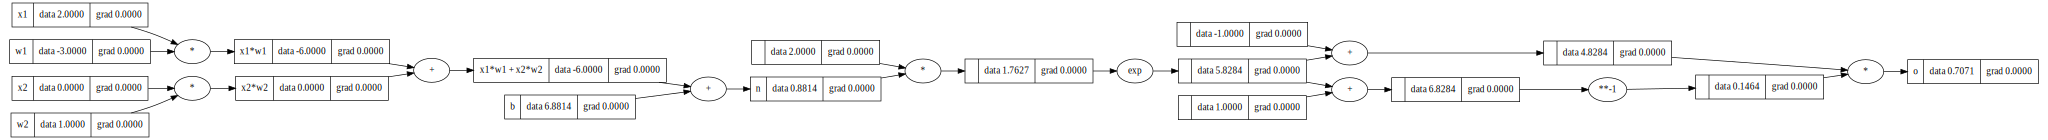

In [19]:
draw_dot(o)

In [ ]:
# 직접 세팅한 grad
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2.grad = 0.5
# w2.grad = 0
# w1.grad = 1.0
# x1.grad = -1.5

In [ ]:
# draw_dot(o)

In [ ]:
# o.backward()

In [ ]:
# o.grad = 1.0

In [ ]:
# n._backward()

In [ ]:
# x1w1x2w2._backward()

In [ ]:
# x2w2._backward()
# x1w1._backward()